##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [ ]:
# !pip install -q tfds-nightly

# # Pin matplotlib version to 3.2.2 since in the latest version
# # transformer.ipynb fails with the following error:
# # https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
# !pip install matplotlib==3.2.2

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

from platform import python_version

In [2]:
print('list won\'t be empty if GPU enabled: ', tf.config.list_physical_devices('GPU'))

print('\nPython Version: ', python_version())

print('\nTF Version: ', tf.__version__)

list won't be empty if GPU enabled:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Python Version:  3.6.9

TF Version:  2.3.1


## Setup input pipeline

Use [TFDS](https://www.tensorflow.org/datasets) to load the [Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

In [3]:
# ######### Full dataset
# # Already downloaded so now we're reading it from disk. If you want to 
# # download to disk you just make the download argument True.

# examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', 
#                                data_dir = 'dataset',
#                                download=False,
#                                with_info=True,
#                                as_supervised=True)
# train_examples, val_examples = examples['train'], examples['validation']


######### Taking a subset of the data to make training faster
# Take 30% of trainset
train_examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', 
                               data_dir = 'dataset',
                               download=False,
                               with_info=True,
                               shuffle_files=True,
                               split='train[:30%]',
                               as_supervised=True)

# Take 10% of val set
val_examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', 
                               data_dir = 'dataset',
                               download=False,
                               with_info=True,
                               shuffle_files=True,
                               split='validation[:10%]',
                               as_supervised=True)

In [4]:
# for port, eng in train_examples.take(5):
#     print(port)
#     print(eng)

next(iter(train_examples))

(<tf.Tensor: shape=(), dtype=string, numpy=b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'>)

Create a custom subwords tokenizer from the training dataset. 

In [5]:
# There is a good loading text notebook which was similar to this which you 
# used to figure out what they're doing to tokanize.

# To learn more about this specific subword text encoder read the docs. 
# https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder
# This builds a SubwordTextEncoder based on the corpus_generator.
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    # This list comprehension looking thing actually made 
    # corpus_generator referring to the comment above this one. 
    # Similar to iter(x for x in dataset_here) but for this we need to created 
    # 2 separate tokenizer, one for each language, and also need to turn each example
    # into numpy when it's iterated over by the .build_from_corpus method.
    corpus_generator=(en.numpy() for pt, en in train_examples),
    target_vocab_size=2**13  # approximate desired size of the vocab to create.
)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus_generator=(pt.numpy() for pt, en in train_examples), 
    target_vocab_size=2**13
)

In [6]:
sample_string = 'Transformer is awesome.'

# Encode the text into list of integers
tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decodes a list of integers back into text.
original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7866, 1369, 7897, 7250, 7814, 13, 2489, 7828]
The original string: Transformer is awesome.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [7]:
# Test the subword encoder. 
# "Transformer" is not in the vocab so it should get broken into subwords.

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7866 ----> T
1369 ----> ran
7897 ----> s
7250 ----> former
7814 ---->  
13 ----> is 
2489 ----> awesome
7828 ----> .


In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [9]:
def numpy_encode(lang1, lang2):
    """
    Takes in tf tensor, converts in to numpy, and adds a start and end token to the 
    encoder input and decoder target input sentences.
    
    Arguments:
    lang1 -- tf tensor, dtype is string. Encoder input sentence.
    lang2 -- tf tensor, dtype is string. Decoder target input sentence.
    
    Return:
    lang1 -- list of tokens (int) with added start and end tokens 
    lang2 -- list of tokens (int) with added start and end tokens 
    """
    
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

# To explain the function above.
# They are using the vocab size as an integer to represent the start token
# and they use the index size+1 to represent the end token since these 2 tokens
# don't exist tokenizers.
portugueseExample, englishExample = next(iter(train_examples))

englishStr = englishExample.numpy()
print(englishStr)

tokenizedEnglishString = tokenizer_en.encode(englishStr)
print ('\nTokenized string is: {}'.format(tokenizedEnglishString))

print('\nAdding start and end tokents: ', 
      [tokenizer_pt.vocab_size] + tokenizedEnglishString + [tokenizer_pt.vocab_size+1])


numpy_encode(portugueseExample, englishExample)

b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

Tokenized string is: [4, 59, 15, 2640, 3999, 2727, 1, 15, 104, 123, 323, 3, 44, 7743, 6, 3542, 1, 86, 13, 2337, 5982, 5619, 2]

Adding start and end tokents:  [8078, 4, 59, 15, 2640, 3999, 2727, 1, 15, 104, 123, 323, 3, 44, 7743, 6, 3542, 1, 86, 13, 2337, 5982, 5619, 2, 8079]


([8078,
  6,
  40,
  4467,
  56,
  3,
  1120,
  1,
  5662,
  12,
  3,
  520,
  6636,
  47,
  19,
  2549,
  141,
  1,
  5,
  8,
  3,
  5721,
  2150,
  5855,
  1434,
  2,
  8079],
 [8038,
  4,
  59,
  15,
  2640,
  3999,
  2727,
  1,
  15,
  104,
  123,
  323,
  3,
  44,
  7743,
  6,
  3542,
  1,
  86,
  13,
  2337,
  5982,
  5619,
  2,
  8039])

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [10]:
def tf_encode(pt, en):
    """
    This will take in the .map tensorflow dataset inputs and feed them into the 
    non-TF (numpy) function which converts the element to numpy, encodes it,
    adds the start and end tokens, and returns back tf tensors so we can train the model. 
    Since the helper function that adds the start and end tokens uses numpy
    we need to wrap it in the tf.py_function() mentioned above.
    
    Arguments:
    pt -- tf tensor, dtype is tf.string. Encoder input sentence.
    en -- tf tensor, dtype is tf.string. Decoder target input sentence.
    
    Return:
    result_pt -- tf tensor, dtype is tf.int64, Encoder input tokens with start and end tokens added.
    result_en -- tf tensor, dtype is tf.int64, Decoder target input tokens with start and 
        end tokens added.
    """
    
    # py_function doesn't set the shape of the returned tensors. You need to define the
    # datatypes of the output when using py_function.
    [result_pt, result_en] = tf.py_function(numpy_encode, 
                                            inp=[pt, en], 
                                            Tout=[tf.int64, tf.int64]
                                           )
    
    # https://stackoverflow.com/questions/35451948/clarification-on-tf-tensor-set-shape
    # https://www.tensorflow.org/tutorials/load_data/text
    # If you don't set the static shape you will get an error with the dataset 
    # padded_batch() method that it has an unknown rank.
    # Rank 0 would be .set_shape([]) IT - from the example in link above.
    # Since each instance is a list of integers, each text should be rank 1 IT.
    # Using None makes it flexible like when you used to use [None, 28, 28, 3] for flexible
    # sizes.
    result_pt.set_shape([None]) # Helps TF know that it's a rank 1 IT. [None, None] is rank 2.
    result_en.set_shape([None])

    return result_pt, result_en



portugueseExample, englishExample = next(iter(train_examples))
display(portugueseExample)

tf_encode(portugueseExample, englishExample)

<tf.Tensor: shape=(), dtype=string, numpy=b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'>

(<tf.Tensor: shape=(27,), dtype=int64, numpy=
 array([8078,    6,   40, 4467,   56,    3, 1120,    1, 5662,   12,    3,
         520, 6636,   47,   19, 2549,  141,    1,    5,    8,    3, 5721,
        2150, 5855, 1434,    2, 8079])>,
 <tf.Tensor: shape=(25,), dtype=int64, numpy=
 array([8038,    4,   59,   15, 2640, 3999, 2727,    1,   15,  104,  123,
         323,    3,   44, 7743,    6, 3542,    1,   86,   13, 2337, 5982,
        5619,    2, 8039])>)

Note: To keep this example small and relatively fast, drop examples with a length of over 40 tokens.

In [11]:
MAX_LENGTH = 40

In [12]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    """Filters only instance pairs that both have size less than max length IT."""
    
    # tf.size() will kinda act as tf.shape except you will get a scalar rank 0 instead
    # of a rank 1 tensor which is in a list. Each instance is list of integers which are
    # token indexes.
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# # cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()

# padded_batch() Combines consecutive elements of this dataset into padded batches.
# This transformation combines multiple consecutive elements of the input dataset into a single element.
# If the dimension is a constant, the component will be padded out to that length in that dimension.
# If the dimension is unknown, the component will be padded out to the maximum length of all elements in that dimension.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [14]:
# Looking at only one batch from each language.
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 34), dtype=int64, numpy=
 array([[8078,   88,  196, ...,    0,    0,    0],
        [8078,  330, 6367, ...,    0,    0,    0],
        [8078, 4601, 7854, ...,    0,    0,    0],
        ...,
        [8078,   60, 1332, ...,    0,    0,    0],
        [8078,  120,   35, ...,    0,    0,    0],
        [8078,   65,  106, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 35), dtype=int64, numpy=
 array([[8038,   12,   21, ...,    0,    0,    0],
        [8038,   96,   25, ...,    0,    0,    0],
        [8038,   12, 2702, ...,    0,    0,    0],
        ...,
        [8038,   16, 1635, ...,    0,    0,    0],
        [8038,   15,   55, ...,    0,    0,    0],
        [8038,   92,  136, ...,    0,    0,    0]])>)

In [15]:
# You can also see that everybatch has a different seq length.
print('Each batch has a different seq length when looking at only 1 language.')
for port, eng in train_dataset.take(5):
    print('')
    print(tf.shape(eng))


Each batch has a different seq length when looking at only 1 language.

tf.Tensor([64 40], shape=(2,), dtype=int32)

tf.Tensor([64 40], shape=(2,), dtype=int32)

tf.Tensor([64 34], shape=(2,), dtype=int32)

tf.Tensor([64 38], shape=(2,), dtype=int32)

tf.Tensor([64 38], shape=(2,), dtype=int32)


## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [16]:
def get_angles(max_rows, dim_model):
  """All I know is that this thing returns a positional matrix shape (token position, subword embedding dim).
  
  Arguments:
  max_rows -- int, num or rows on y-axis. y-axis of visualization below in notebook. 
  dim_model -- int, dimension of word embedding. x-axis of visualization below in notebook.
  
  Return:
  numpy matrix, shape (token_position, subword dim embedding)
  """

  # Makes into column of all positions leading up to this position. For example, 
  # if the position is 12 you can a column vector shape (12, 1) 0, 1,2,3,4...12.
  # This is the same as np.expand_dims(np.arange(position), 1)
  y_axis = np.arange(max_rows)[:, np.newaxis]
#   import pdb;pdb.set_trace()
  # This creates a row vector shape (1, dim_model) 0,1,2,3...512.
  # This is the same as np.expand_dims(np.arange(dim_model), 0)
  x_axis = np.arange(dim_model)[np.newaxis, :]

  angle_rates = 1 / np.power(10000, (2 * (x_axis//2)) / np.float32(dim_model))
  
  return y_axis * angle_rates


In [17]:
display(get_angles(50, 512).shape)
get_angles(50, 512)#.shape


(50, 512)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 9.64661620e-01, ...,
        1.07460783e-04, 1.03663293e-04, 1.03663293e-04],
       [2.00000000e+00, 2.00000000e+00, 1.92932324e+00, ...,
        2.14921566e-04, 2.07326586e-04, 2.07326586e-04],
       ...,
       [4.70000000e+01, 4.70000000e+01, 4.53390961e+01, ...,
        5.05065679e-03, 4.87217476e-03, 4.87217476e-03],
       [4.80000000e+01, 4.80000000e+01, 4.63037578e+01, ...,
        5.15811758e-03, 4.97583806e-03, 4.97583806e-03],
       [4.90000000e+01, 4.90000000e+01, 4.72684194e+01, ...,
        5.26557836e-03, 5.07950135e-03, 5.07950135e-03]])

In [18]:
def positional_encoding(max_row_dimension_of_position_embedding, dim_model):
  """Make a positional encoding matrix. Later on, this matrix will be sliced according to 
  max length seq of each padded batch and then added to the word embedding. I don't know
  why they do it like this because you could've just used the size of the max seq length
  of the batch to determine the num of rows in the x-axis because it's the same exact thing
  (you can see this is the proof a few cells below).

  Arguments:
  max_row_dimension_of_position_embedding -- int, you choose but has to be bigger than the max
  seq length of all the batches.
  dim_model -- int, dimension of word embedding
  
  Return:
  tf Tensor of rank 3, shape (1,max rows from argument, dimension of word embedding; prolly 512)
  """

  angle_rads = get_angles(
      max_row_dimension_of_position_embedding, 
      dim_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  # don't know whey but they added another axis at beginning. Not sure if it's 
  # for batches??
  pos_encoding = angle_rads[np.newaxis, ...]
    
  # Convert this numpy array into a tensorflow Tensor because this output 
  # is going to be added to another tf tensor during training so it MUST BE A TF TENSOR.
  return tf.cast(pos_encoding, dtype=tf.float32)



tf.Tensor([    1 30000   512], shape=(3,), dtype=int32)


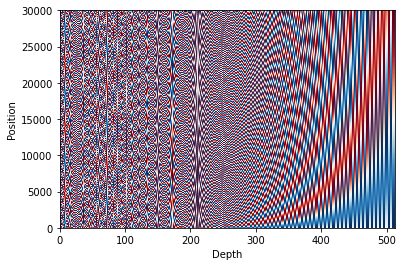

In [19]:
pos_encoding = positional_encoding(30_000, 512)
print (tf.shape(pos_encoding))

plt.pcolormesh(pos_encoding[0].numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
# plt.colorbar()
plt.show()

In [ ]:
pos_encoding = positional_encoding(3_000, 512)
print (tf.shape(pos_encoding))

plt.pcolormesh(pos_encoding[0].numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
# plt.colorbar()
plt.show()

In [ ]:
sliceSubsetofLargePosEncoding = 300

plt.pcolormesh(pos_encoding[0][:sliceSubsetofLargePosEncoding, :].numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
pos_encoding = positional_encoding(300, 512)
print (tf.shape(pos_encoding))

plt.pcolormesh(pos_encoding[0].numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# The 2 positional encoding above are identical. Taking a subset of the larger positional 
# encoding is the same as making a positional encoding with the function using a smaller
# value in the argument.
assert np.sum(~(pos_encoding[0][:sliceSubsetofLargePosEncoding, :].numpy() == pos_encoding))==0, 'The 2 positional encodings are NOT identical'

In [ ]:
# The range of values in the matrix is [-1, 1].
# Notice that the number of rows in axis 1 is the is a max seq length of the batch which is
# sliced from the original rows which was the number of subwords in the subwords. 
# No clue why they do that.
pos_encoding

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [20]:
def create_padding_mask(seq):
  """
  Turns all padded 0's into 1's and everything else into 0's. 
  
  Arguments:
  seq -- tf tensor of dtype=tf.int32, shape (batch_size, seq_length_of_batch) 
  
  Return:
  tf tensor of dtype=tf.float32, only binary with padded 0's converted to 1's.
      Returning shape (batch_size, 1, 1, batch_seq_len)
  """

  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 0], [1, 2, 3, 0, 0], [4, 5, 9, 4, 0]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 1.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 1.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [22]:
def create_look_ahead_mask(batch_of_tokens):
  """Creates a matrix from an array (seq of tokens from a sentance) sequence IT so that each row
  is seeing one sequence at a time (masks all tokens after token index).
  Look at example below, remember that 1 is the mask which means do not use that as input.
  
  Arguments:
  batch_of_tokens -- tf tensor, array shape (1, batch seq len)
  
  Return:
  tf tensor matrix, shape (batch seq len, batch seq len). This masks all future tokens at
      each timestep in the 1st sublayer decoder multi-attention head."""
    
  # Makes a matrix of ones based on batch seq length.
  # The num_lower and num_upper combo (-1, 0) is a special case that means lower triangle part.
  # At this point, we get a matrix of 0s and 1s but in opposite so we flip them
  # by substracting everything by 1.
  mask = 1 - tf.linalg.band_part(tf.ones((batch_of_tokens, batch_of_tokens)), -1, 0)
  
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((4, 3))
print(x)
temp = create_look_ahead_mask(x.shape[1])
temp

In [23]:
def create_masks(inp, tar):
  """Creates padding masks:
  1. The encoder padding mask which just masks the padded batches
  2. The look ahead mask which pads all future tokens at each timestep.
  
  Arguments:
  inp -- tf tensor dtype=tf.int64, encoder batch of tokens. Shape (batch size, batch seq len)
  tar -- tf tensor dtype=tf.int64, decoder target batch of tokens. 
      Shape (batch size, batch seq len)
  
  Return:
  encoder_input_and_output_padding_mask -- tf tensor dtype=tf.float32, Turns all padded 0's 
      into 1's and everything else into 0's. 
      Shape (batch size, 1, 1, batch input seq len)
  look_ahead_mask -- tf tensor dtype=tf.float32, look ahead mask for each instance.
      Shape (batch size, 1, batch seq len, batch seq len)
  """

  # This padding mask will be used as the Encoder padding mask (way down below in the notebook) 
  # AND used to mask the encoder outputs which are used in the 2nd attention sublayer
  # in the decoder.
  encoder_input_and_output_padding_mask = create_padding_mask(inp)
  
  ## Create the look ahead mask so the decoder input 1st attention block only sees itself and 
  ## previous tokens at each timestep; prevents seeing future timestep tokens. 
  # Used in the 1st attention block in the decoder.
  target_look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  target_decoder_padding_mask = create_padding_mask(tar)
  look_ahead_mask = tf.maximum(target_decoder_padding_mask, target_look_ahead_mask)
  
  return encoder_input_and_output_padding_mask, look_ahead_mask



In [ ]:
x = tf.constant([[3, 6, 9, 2, 0], 
                 [90, 2, 0, 0, 0], 
                 [30, 288, 1, 0, 0]])  # shape (3, 5)

y = tf.constant([[493, 5, 0, 0, 0, 0, 0], 
                 [56, 355, 1, 3, 4, 0, 0], 
                 [3, 56, 23, 0, 0, 0, 0]])  # shape (3, 7)

encInput_and_OutputPadding_mask, targetLookAheadAndMaskPad = create_masks(x, y)
print('Input padding mask used for ENCODER\'S input and also used to mask the ENCODER\'S output \
which are used in the 2nd attention block of the DECODER multi-attention.')
display(encInput_and_OutputPadding_mask)
print('\n\nTarget look ahead and padding mask combined. It is used in the 1st attention block in the decoder. \
It is used to pad and mask future tokens at each timestep in the decoder input.')
display(targetLookAheadAndMaskPad)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `last dimesion of axis k (or q, they're the same)`. Hence, *square root of `last dimesion of axis k (or q, they're the same)`* will result in the standard deviation and this is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax. Look at the cell below to see it yourself.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

<font size="5"> * The attention weights are of the output of the softmax in the figure above.</font>

In [ ]:
q = tf.random.normal((24, 12, 5, 70), mean=0.0, stddev=1.0)
k = tf.random.normal((24, 12, 4, 70), mean=0.0, stddev=1.0)
# Transpose 'k' so the dimensions work for the matrix multiplication
k = tf.transpose(k, perm=(0, 1, 3, 2))

qMatMulk = tf.matmul(q, k)
var = tf.math.reduce_variance(qMatMulk)

print('variance of the matrix multiplication is about equal to the dimension \
in the last axis:\n', var.numpy())

# Get the standard deviation of the variance by taking square root
std = tf.sqrt(var)

# Scale (same concept as feature scaling) by dividing by std so the std, or variance,
# becomes 1.
scaledMatrix = tf.math.reduce_variance(qMatMulk/std)
# This would've been the same as std because 
# the square root of variance = 1 is also equal to 1.
print('\nScaled matrix variance: ', scaledMatrix.numpy())


In [24]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights and the dot product of the attention weights and value (v).
  q, k, v must have matching leading dimensions (I think he means same dimensions in ':-2' axis).
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v. In other words,
  they must have matching dimension in the second to last axis.
  The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
  3 possible v, k, q scenerios and their respective mask:
  1. q, k, v are all inputs on the encoder side; encoder mask.
  2. q, k, v are all inputs from the decoder side; look ahead mask.
  3. k and v are passed the same object which came from the ENCODER output. 
      q is passed an output that came from within the DECODER; encoder mask 
  
  Args:
    q -- tf tensor dtype=tf.float32, 
        query shape == (batch_size, num_heads, batch_seq_len_q, depth)
    k -- tf tensor dtype=tf.float32,
        key shape == (batch_size, num_heads, batch_seq_len_k, depth)
    v -- tf tensor dtype=tf.float32,
        value shape == (batch_size, num_heads, batch_seq_len_v, depth)
    mask: Float tensor that has different shapes depending on its type (padding
        or look ahead). Regardless of the shape, it must be broadcastable 
        to (..., decoder_batch_seq_len, encoder_batch_seq_len). Defaults to None.
    
  Returns:
    scaled_dot_product_attn_output: Output of attention head. 
        Shape (batch_size, num_heads, batch_seq_len_q, depth_v)
    attention_weights: Weights that are used to determine which indexes in the sequence to focus on.
        shape (batch_size, num_heads, batch_seq_len_q, seq_len_k)
  """

  # This matrix multiplication will only flip the last 2 axis for the transpose.
  # q: query shape == (batch_size, num_heads, batch_seq_len_q, depth)
  # transposedk: key shape == (batch_size, num_heads, depth, seq_len_k)
  # output shape:(batch_size, num_heads, batch_seq_len_q, batch_seq_len_k)
  matmul_qk = tf.matmul(q, k, transpose_b=True)  

  # It seems the variance of the matrix multiplication above is equal to,
  # or close to, the last dimension of q and k (same number).
  # To make this scaled you just have to divide by the std. The std is the square root of the
  # variance. So, when you divide by the std you know have a scaled matrix that will
  # have a mean=0 and std=1
  var = tf.cast(tf.shape(k)[-1], tf.float32)
  std = tf.math.sqrt(var)
  scaled_attention_logits = matmul_qk / std

  # Add the mask to the scaled tensor. Look at scenerios above in the description.
  # Scenerio 1: scaled_attention_logits shape (..., batch_enc_len, batch_enc_len); 
    # mask shape (batch_size, 1, 1, batch_enc_len)
  # Scenerio 2: scaled_attention_logits shape (..., batch_dec_len, batch_dec_len); 
    # Look ahead mask, shape (batch_size, 1, batch_dec_len, batch_dec_len) 
  # Scenerio 3: scaled_attention_logits shape (..., batch_dec_len, batch_enc_len); 
    # mask shape (batch_size, 1, 1, batch_enc_len)   
  # The mask is multiplied with -1e9 (close to negative infinity). This is done because 
  # the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately 
  # before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are 
  # near zero in the output.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1. Output shape (..., batch_seq_len_q, seq_len_k)
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  
  
  # This uses the attention weights to pretty much keep only the values it's interested in
  # and get rid of the ones that it doesn't want to pay attention to.
  # output shape (..., batch_seq_len_q, depth_v)    
  scaled_dot_product_attn_output = tf.matmul(attention_weights, v)

  return scaled_dot_product_attn_output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
# This seems to round to whole number instead of printing scientific format.
np.set_printoptions(suppress=True)


# query example
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# key example
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

# value example
temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key` in temp_k,
# so the second `value` is returned.
print_out(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
# NOTICE THIS IS A LITTLE DIFFERENT THE THE CELL ABOVE BECAUSE 
# IT IS NOT A REPEATED KEY.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print('temp query')
temp_q

In [ ]:
print_out(temp_q, temp_k, temp_v)

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
  """Take in v, k, q and perfom the whole multi-head attention calculation.
  
  ### Initialize
  Arguments:
  dim_model -- int, dim of the model
  num_heads -- int, num of multi-attention heads
  """

  def __init__(self, dim_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.dim_model = dim_model
    
    # Making sure that splitting the dimensions into heads is perfectly divided.
    assert dim_model % self.num_heads == 0
    
    # This is floor division
    self.depth = dim_model // self.num_heads
    
    # Make Dense layers with output of dimensions of model
    # This is the layer we use to create the actual values, keys, and queries.
    self.wq = tf.keras.layers.Dense(dim_model)
    self.wk = tf.keras.layers.Dense(dim_model)
    self.wv = tf.keras.layers.Dense(dim_model)
    
    # The final linear Dense layer in the picture above
    self.dense = tf.keras.layers.Dense(dim_model)
        
  def split_heads(self, x, batch_size):
    """
    Split the inputs last dimension into (num_heads, depth) and transpose the result such 
    that the shape is (batch_size, num_heads, seq_len, depth).
    I guess it can't be done in one step using only reshape.
    For example, if the dim of the model is 512 then splitting it into 8 heads would make 
    the dimensions of each head reduced from 512 to 64 dimensions.
    
    Arguments:
    x -- tf tensor, shape (batch_size, batch_seq_length, dim_model)
    batch_size -- self-explanatory
    
    Return:
    The split heads, tf tensor, shape (batch_size, num_heads, batch_seq_len, depth)
    """
    
    # x reshape output (batch_size, seq_length, num_heads, depth)
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    
    # transposing output shape (batch_size, num_heads, batch_seq_len, depth)
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, pre_v, pre_k, pre_q, mask):
    """
    Pass the building block of v, k, q and transform it to v, k, and q. Then split
    them into multiple heads. Then, pass them to the scaled_dot_product_attentions_function and 
    concat the heads back together and pass it though a dense layer to complete the calculation.
    
    
    Arguments:
    pre_v -- tf tensor, building block of value
    pre_k -- tf tensor, building block of key
    pre_q -- tf tensor, building block of query
    mask -- tf tensor or None, padding mask, look ahead mask, or None
    
    multihead_attention_output -- tf tensor, Shape (batch_size, input_batch_seq_len ,dim_model)
    attention_weights -- tf tensor, Shape (batch_size, num_heads, batch_seq_len_q, batch_seq_len_k)
    """
    
    
    batch_size = tf.shape(pre_q)[0]
    
    # Create values, keys, and queries for the batch.
    q = self.wq(pre_q)  # output shape (batch_size, seq_len, dim_model)
    k = self.wk(pre_k)  # output shape (batch_size, seq_len, dim_model)
    v = self.wv(pre_v)  # output shape (batch_size, seq_len, dim_model)
    
    # Split dim_model into multiple heads; this will reduce dimensions (depth).
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # attention_head_output.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    attention_head_output, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    # Transpose to move axes, output shape (batch_size, seq_len_q, num_heads, depth)
    attention_head_output = tf.transpose(attention_head_output, perm=[0, 2, 1, 3])
    
    # Concat all the head back together. Shape (batch_size, seq_len_q, dim_model)
    concat_attention = tf.reshape(attention_head_output, 
                                  (batch_size, -1, self.dim_model))  

    # Pass through a linear layer for multihead attention output.
    multihead_attention_output = self.dense(concat_attention)  
        
    return multihead_attention_output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(dim_model=512, 
                              num_heads=8
                             )

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
multiheadAttentionOutput, attnWeights = temp_mha(pre_v=y,
                     pre_k=y,
                     pre_q=y, 
                     mask=None)
multiheadAttentionOutput.shape, attnWeights.shape

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [26]:
def point_wise_feed_forward_network(dim_model, dim_feed_forward):
  """Simple fully connected network; dim_model --> dim_feed_forward --> dim_model"""

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dim_feed_forward, activation='relu'),  # (batch_size, seq_len, dim_feed_forward)
      tf.keras.layers.Dense(dim_model)  # (batch_size, seq_len, dim_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
  """Create a Encoder layer which consists of 2 sublayers; multi-head attention and
  a fully connected network.
  
  ### Initialize
  Arguments:
  dim_model -- int, dim of the model
  num_heads -- int, num of multi-attention heads
  feed_forward_hidden_layer_dim -- int, dim of hidden layer in the fully connected netword sublayer of the 
      encoderlayer and decoderlayer.
  rate -- float, dropout rate to prevent over-fitting
  """

  def __init__(self, dim_model, num_heads, feed_forward_hidden_layer_dim, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(dim_model, num_heads)
    self.fully_connected_network = point_wise_feed_forward_network(dim_model, feed_forward_hidden_layer_dim)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropsublayer_output_1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, encoder_layer_input, training, padding_mask):
    """The input into the muli-attention head is the positional encodding + embedding or the output
    of another Encoder layer. Look at the fig above and you'll see Nencoder_layer_input for Encoder layers so there
    are multiple Encoder layers.
    
    Arguments:
    encoder_layer_input -- word embedding + positional encoding (batch_size, encoder_batch_seq_length, emb dim),
        or the output of a previous Encoder layers (batch_size, encoder_batch_seq_length, emb dim)
    training -- boolean (True or False)
    padding_mask -- tf tensor dtype=tf.float32, encoder padding mask shape (batch_size, 1, 1, encoder_batch_seq_len)
    
    Return:
    sublayer_output_2 -- tf tensor, output of an encoder layer.
        Shape (batch_size, encoder_batch_input_seq_len, dim_model)
    """

    # Looks like the input for query, key, and values is the same; the input.
    multihead_attn_output, _ = self.mha(pre_v=encoder_layer_input, 
                                        pre_k=encoder_layer_input, 
                                        pre_q=encoder_layer_input, 
                                        mask=padding_mask)  # output (batch_size, input_batch_seq_len, dim_model)
    # Looks like dropout is appled to the output of the multihead attention to prevent overfitting IT.
    multihead_attn_output = self.dropsublayer_output_1(multihead_attn_output, training=training)
    
    # Residual connection to avoid vanihsing gradient problem in deep networks.
    sublayer_output_1 = self.layernorm1(encoder_layer_input + multihead_attn_output)  # output (batch_size, input_batch_seq_len, dim_model)
    
    # Feed Forward Network
    # output shape (batch_size, input_batch_seq_len, dim_model)
    fully_connected_network_output = self.fully_connected_network(sublayer_output_1)  
    fully_connected_network_output = self.dropout2(fully_connected_network_output, training=training)
    
    # Residual connection to avoid vanihsing gradient problem in deep networks.
    sublayer_output_2 = self.layernorm2(sublayer_output_1 + fully_connected_network_output)  # Output (batch_size, input_batch_seq_len, dim_model)
    
    return sublayer_output_2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None) # batch_size, seq_length, emb_dim

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
  """
  Create a Encoder layer which consists of 3 sublayers; multi-head attention with look ahead
  mask, multi-head attention with padding mask, and a fully connected network.
  
  ### Initialize
  Arguments:
  dim_model -- int, dim of the model
  num_heads -- int, num of multi-attention heads
  feed_forward_hidden_layer_dim -- int, dim of hidden layer in the fully connected netword sublayer of the 
      encoderlayer and decoderlayer.
  rate -- float, dropout rate to prevent over-fitting
  """

  def __init__(self, dim_model, num_heads, feed_forward_hidden_layer_dim, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(dim_model, num_heads)
    self.mha2 = MultiHeadAttention(dim_model, num_heads)

    self.ffn = point_wise_feed_forward_network(dim_model, feed_forward_hidden_layer_dim)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropsublayer_output_1 = tf.keras.layers.Dropout(rate)
    self.dropsublayer_output_2 = tf.keras.layers.Dropout(rate)
    self.dropsublayer_output_3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, decoder_layer_input, enc_output, training, look_ahead_mask, padding_mask):
    '''Calculates decoder layer which can be used to create multiple decoder layers Nx times
    (fig above). There are 3 sublayers:
    1. multi-head attention with look ahead mask
    2. multi-head attention with padding mask
    3. a fully connected network.
    The function does NOT include the linear to softmax calculation to get output probabilities.
    
    Arguments:
    decoder_layer_input -- tr tensor, shape (batch_size, decoder_batch_seq_length, dim model)
    enc_output -- self-edecoder_layer_inputplanatory, shape (batch_size, input_seq_len, dim model)
    training -- boolean (True or False), used for dropout during training to prevent overfitting
    look_ahead_mask -- tf tensor dtype=tf.float32, masks all future tokens at each timestep.
        Shape (decoder batch input seq len, decoder batch input seq len)
    pading_mask -- tf tensor dtype=tf.float32, input padding mask.
        Shape (batch_size, 1, 1, encoder batch input seq len)
        
    Return:
    sublayer_output_3 -- tf tensor, output of decoder layer which is sublayer 3, 
        Shape (batch_size, decoder input batch seq len, dim_model)
    attn_weights_block1 -- tf tensor, attention weights from sublayer 1 which uses look ahead mask.
        Shape (batch_size, decoder input batch seq len, dim_model)
    attn_weights_block2 -- tf tensor, attention weights from sublayer 2 which uses look ahead mask.
        Shape (batch_size, decoder input batch seq len, dim_model)
    '''

    
    ## Sublayer 1
    # Just like the encoder layer, the first layer of the decoder 
    # uses the same value for query, key, and values; decoder input.
    multihead_attn_output_1, attn_weights_block1 = self.mha1(pre_v=decoder_layer_input, 
                                           pre_k=decoder_layer_input, 
                                           pre_q=decoder_layer_input, 
                                           mask=look_ahead_mask
                                                            ) 
    
    multihead_attn_output_1 = self.dropsublayer_output_1(multihead_attn_output_1, training=training)
    # Residual connection to avoid vanihsing gradient problem in deep networks.
    sublayer_output_1 = self.layernorm1(multihead_attn_output_1 + decoder_layer_input)
    
    
    ## Sublayer 2
    # Now you are going to use the output above as the query
    # and the encoder ouput as the key and values.
    multihead_attn_output_2, attn_weights_block2 = self.mha2(pre_v=enc_output, 
                                           pre_k=enc_output, 
                                           pre_q=sublayer_output_1, 
                                           mask=padding_mask  
                                                            )  
    multihead_attn_output_2 = self.dropsublayer_output_2(multihead_attn_output_2, training=training)
    sublayer_output_2 = self.layernorm2(multihead_attn_output_2 + sublayer_output_1)  # (batch_size, target_seq_len, dim_model)
    
    
    ## Sublayer 3; pass through simple fully connected network
    ffn_output = self.ffn(sublayer_output_2)
    ffn_output = self.dropsublayer_output_3(ffn_output, training=training)
    sublayer_output_3 = self.layernorm3(ffn_output + sublayer_output_2)  # (batch_size, target_seq_len, dim_model)
    
    return sublayer_output_3, attn_weights_block1, attn_weights_block2


In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(decoder_layer_input=tf.random.uniform((64, 50, 512)), 
                                                         enc_output=sample_encoder_layer_output, 
                                                         training=False, 
                                                         look_ahead_mask=None, 
                                                         padding_mask=None)


sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)


### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [29]:
class Encoder(tf.keras.layers.Layer):
  """The Encoder consists of:
  1. Input embedding
  2. Positional Encoding
  3. N encoder layers
      
  The input is put through an embedding which is summed with the positional encoding. 
  The output of this summation is the input to the encoder layers. 
  The output of the encoder is the key and values input to the decoder's multihead 
  attntion in the 2nd sublayer. Look at the fig above.
  
  ### Initialize
  Arguments:
  num_layers -- int, num of layers; Nx
  dim_model -- int, dim of the model
  num_heads -- int, num of multi-attention heads
  feed_forward_hidden_layer_dim -- int, dim of hidden layer in the fully connected netword sublayer of the 
      encoderlayer and decoderlayer.
  input_vocab_size -- int, size of input vocab
  maximum_position_encoding -- int, sets num of rows for positition encoding. (Note: you were able to
      prove that this is completely unnecessary because it it going get sliced anyway and the slice
      can be identically by setting this to the batch seq length).
  rate -- float, dropout rate to prevent over-fitting
  """
    
  def __init__(self, num_layers, 
               dim_model, num_heads, 
               feed_forward_hidden_layer_dim, 
               input_vocab_size,
               maximum_position_encoding, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.dim_model = dim_model
    self.num_layers = num_layers
    
    # Word embedding
    # Embeds words from vocab size dims to embedded word dimensions.
    self.embedding = tf.keras.layers.Embedding(input_dim=input_vocab_size, output_dim=dim_model)
    
    # Positional encoding
    # Output shape (1, maximum num or rows, 
    #   dimension of word embedding; prolly 512)
    self.maximum_position_encoding = positional_encoding(maximum_position_encoding, 
                                            self.dim_model)
    
    # Making Nx encoder layers from figure above
    self.enc_layers = [EncoderLayer(dim_model, num_heads, feed_forward_hidden_layer_dim, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
        
  def call(self, x, training, mask):
    '''
    Arguments:
    x -- tf Tensor, batch_size of token sequences. shape (batch_size, batch_input_seq_length)
    Each batch has different padded seq length; each instance in a batch doesn't have a different
    seq length though. For example, batch 1: (64, 49), batch 2 (64, 45),...
    training -- True or False, used to apply dropout during training to prevent over-fitting.
    mask -- tf tensor dtype=tf.float32, encoder padding mask shape (batch_size, 1, 1, encoder_batch_seq_len)
    
    Return:
    ouput of encoder -- tf Tensor, shape (batch_size, input_batch_seq_len, dim_model)
    '''

    # Get seq length of the batch
    seq_len = tf.shape(x)[1]
    
    #### adding embedding and position encoding.
    # Embedding takes in batches of tokens and embeds the tokens to dim_model dimensions.
    # Input shape (batch_size, batch_input_seq_length)
    # output shape (batch_size, batch_input_seq_len, dim_model)
    x = self.embedding(x)  
    
    # Some type of element multiplication by the sqrt of the dimensions of the model
    # I don't know why we do this but if the dim model is bigger than 1 than 
    # the word embeddings values will become larger after the multiplication.
    x *= tf.math.sqrt(tf.cast(self.dim_model, tf.float32))
    
    # Slicing from the position encoding matrix. You set the max size of the position encoding
    # matrix and this will slice only up to the rows which is also the seq length of the batch.
    # For example, if you had the positional encoding matrix shape (10,000, 512) and the batch seq
    # length is 40 then you will slice a submatrix of shape (40 512) from the positioanl encoding matrix.
    # This gets added to the word embedding.
    x += self.maximum_position_encoding[:, :seq_len, :]

    # Prevent overfitting during training
    x = self.dropout(x, training=training)
    
    # Do this for Nx layers
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # output shape (batch_size, input_seq_len, dim_model)


In [ ]:
sample_encoder = Encoder(num_layers=2, 
                         dim_model=512, 
                         num_heads=8, 
                         feed_forward_hidden_layer_dim=2048, 
                         input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, batch_input_seq_len, d_model)



### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [30]:
class Decoder(tf.keras.layers.Layer):
  """The Decoder consists of:
  1. Output word Embedding
  2. Positional encoding
  3. Nx decoder layers
    
  The target is put through an embedding which is summed with the positional encoding. 
  The output of this summation is the input to the decoder layers. 
  The output of the decoder is the input to the final linear layer (which is not in this class).
  
  ### Initialize
  Arguments:
  dim_model -- int, dim of the model
  num_heads -- int, num of multi-attention heads
  feed_forward_hidden_layer_dim -- int, dim of hidden layer in the fully connected netword sublayer of the 
      encoderlayer and decoderlayer.
  target_vocab_size -- int, size of target vocab
  maximum_position_encoding -- int, sets num of rows for positition encoding. (Note: you were able to
      prove that this is completely unnecessary because it it going get sliced anyway and the slice
      can be identically by setting this to the batch seq length).
  rate -- float, dropout rate to prevent over-fitting
  """

  def __init__(self, num_layers, 
               dim_model, 
               num_heads, 
               feed_forward_hidden_layer_dim, 
               target_vocab_size,
               maximum_position_encoding, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.dim_model = dim_model
    self.num_layers = num_layers
    
    # Create word embedding and position encoding
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, dim_model)
    self.maximum_position_encoding = positional_encoding(maximum_position_encoding, dim_model)
    
    # Create Nx decoder layers
    self.dec_layers = [DecoderLayer(dim_model, num_heads, feed_forward_hidden_layer_dim, rate) 
                       for _ in range(num_layers)]
    
    # Create dropout layer to prevent over-fitting
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    '''
    Arguments:
    x -- tf Tensor, batch_size of token sequences. shape (batch_size, batch_decoder_input_seq_length)
    Each batch has different padded seq length; each instance in a batch doesn't have a different
    seq length though. For example, batch 1: (64, 49), batch 2 (64, 45),...
    enc_output -- tf tensor, output of Encoder. Shape (batch_size, encoder_batch_seq_len, dim_model)
    training -- boolean (True or False), used for training with dropout to prevent overfitting.
    look_ahead_mask -- tf tensor dtype=tf.float32, look ahead mask to prevent token from seeing future
        timesteps at each timestep. Shape (decoder input batch seq len, decoder input batch seq len)
    padding_mask -- tf tensor dtype=tf.float32, encoder padding mask shape (batch_size, 1, 1, encoder_batch_seq_len)
    
    Return:
    x -- tf Tensor, shape (batch_size, input_batch_seq_len, dim_model)
    attention_weights -- dictionary of Tensors, has 1st and 2nd sublayer attention weights of each layer.
    '''

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    #### adding embedding and position encoding.
    # Embedding takes in batches of tokens and embeds the tokens to dim_model dimensions.
    # Input shape (batch_size, batch_input_seq_length)
    # output shape (batch_size, batch_input_seq_len, dim_model)
    x = self.embedding(x)  # (batch_size, target_seq_len, dim_model)
    
    # Some type of element multiplication by the sqrt of the dimensions of the model
    # I don't know why we do this but if the dim model is bigger than 1 than 
    # the word embeddings values will become larger after the multiplication.
    x *= tf.math.sqrt(tf.cast(self.dim_model, tf.float32))
    
    # Slicing from the position encoding matrix. You set the max size of the position encoding
    # matrix and this will slice only up to the rows which is also the seq length of the batch.
    # For example, if you had the positional encoding matrix shape (10,000, 512) and the batch seq
    # length is 40 then you will slice a submatrix of shape (40 512) from the positioanl encoding matrix.
    # This gets added to the word embedding.
    x += self.maximum_position_encoding[:, :seq_len, :]
    
    # Prevent overfitting during training.    
    x = self.dropout(x, training=training)

    # Do this for Nx layers
    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, dim_model)
    return x, attention_weights


In [ ]:
maxTargetSeqLength = 50

sample_decoder = Decoder(num_layers=2, 
                         dim_model=512, 
                         num_heads=8, 
                         feed_forward_hidden_layer_dim=2048, 
                         maximum_position_encoding=8000, 
                         target_vocab_size=8000)
temp_input = tf.random.uniform((64, maxTargetSeqLength), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [31]:
class Transformer(tf.keras.Model):
  """
  Create the transfer model. It will consist of the Encoder, Decoder and final linear layer.
  The output of the of Decoder is the input to the linear layer and its output is returned.
  
  ### Initialize
  Arguments:
  num_layers -- int, num of layers; Nx
  dim_model -- int, dim of the model
  num_heads -- int, num of multi-attention heads
  feed_forward_hidden_layer_dim -- int, dim of hidden layer in the fully connected netword sublayer of the 
      encoderlayer and decoderlayer.
  input_vocab_size -- int, size of input vocab
  target_vocab_size -- int, size of target vocab
  maximum_position_encoding -- int, sets num of rows for positition encoding. (Note: you were able to
      prove that this is completely unnecessary because it it going get sliced anyway and the slice
      can be identically by setting this to the batch seq length).
  rate -- float, dropout rate to prevent over-fitting
  """
  def __init__(self, 
               num_layers, 
               dim_model, 
               num_heads, 
               feed_forward_hidden_layer_dim, 
               input_vocab_size, 
               target_vocab_size, 
               maximum_position_encoding, 
               rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, dim_model, num_heads, feed_forward_hidden_layer_dim, 
                           input_vocab_size,
                           maximum_position_encoding,
                           rate)

    self.decoder = Decoder(num_layers, dim_model, num_heads, feed_forward_hidden_layer_dim, 
                           target_vocab_size, 
                           maximum_position_encoding,
                           rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, 
           inp, 
           tar, 
           training, 
           enc_padding_mask, 
           look_ahead_mask):
    """Passes the input into this model and outputs the final result of the Transformer model
    and attention weights of the 2nd multi-head attention function from the last Nx layer
    
    Arguments:
    inp -- tf tensor, encoder input of batches of instances which contain tokens. 
        Shape (batch_size, encoder_batch_input_seq_len)
    tar -- tf tensor, decoder input of batches of instances which contain tokens. During
        Training this would be the target sentence. Shape (batch_size, decoder_batch_input_seq_len)
    training -- boolean (True or False), used for using dropout during training to prevent over-fitting
    enc_padding_mask -- tf tensor dtype=tf.float32, Turns all padded 0's 
      into 1's and everything else into 0's.
      Shape (batch size, 1, 1, encoder batch input seq len)
    look_ahead_mask -- tf tensor dtype=tf.float32, look ahead mask for each instance.
      Shape (batch size, 1, batch seq len, batch seq len)
      
    Return:
    final_ouput -- tf tensor dtype=tf.float32, final output of Transformer model, it has a prediction
        at each timestep with the index of the highest value in the last axis as the prediction of that
        timestep. Shape (batch_size, decoder_input_batch_seq_len, target_vocab_size)
    attention_weights -- dictionary of Tensors, has 1st and 2nd sublayer attention weights of each 
        Decoder N-layer.   
    """

    # Pass inputs into Encoder
    # Output shape (batch_size, input_batch_seq_len, dim_model)
    enc_output = self.encoder(inp, training, enc_padding_mask)
    
    # Pass the Decoder input into the Decoder. The Encoder output will be used in the 2nd sublayer of the 
    # Decoders multi-head attention as "value" and "key". 
    # dec_output (batch_size, tar_seq_len, dim_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, enc_padding_mask)
    
    # Pass the output through a linear Dense layer which vocab_size neurons.
    final_output = self.final_layer(dec_output)  
    
    return final_output, attention_weights



In [ ]:
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)


sample_transformer = Transformer(
    num_layers=2, dim_model=512, num_heads=8, feed_forward_hidden_layer_dim=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    maximum_position_encoding=6000)


fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [32]:
num_layers = 4
dim_model = 128
feed_forward_hidden_layer_dim = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

# num_layers = 6
# dim_model = 512
# feed_forward_hidden_layer_dim = 2048
# num_heads = 8

# input_vocab_size = tokenizer_pt.vocab_size + 2
# target_vocab_size = tokenizer_en.vocab_size + 2
# dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  """A custom learning rate scheduler which linearly ramps up the learning rate during the 
  warmpup steps and then does some type of decay rate decline over time.
  
  ### Initialize
  dim_model -- int, dim of model
  warmup_steps -- int, warm up steps
  """

  def __init__(self, dim_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.dim_model = dim_model
    self.dim_model = tf.cast(self.dim_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    """In the formula, the arg2 will be what is multiplied all the way up to the warmup steps. 
    Seems like this makes the linear increase of the schedule and once it surpasses the warmup 
    steps, the recipricol square root will instead start to get multiplied, acting as the multiplier,
    and start making the slower exponential learning rate decline.
    
    Arguments:
    step -- tf tensor, range of steps i.e. 1,2,3,4,5,etc.
    
    Returns:
    tf tensor -- learning rate schedule at each training step.
    """
    
    # .rsqrt is RECIPROCAL square root
    arg1 = tf.math.rsqrt(step) # This is some type of slower rate decay
    arg2 = step * (self.warmup_steps ** -1.5)  # This is a linear increase as the step increases
    
    # .rsqrt is RECIPROCAL square root
    # If the steps is lower than the warmup steps, then the arg2 (linear increase) controls
    # and the learning rate linearly increases. Once the steps reaches the warmpup steps then
    # arg1 will take over and slowly decrease.
    return tf.math.rsqrt(self.dim_model) * tf.math.minimum(arg1, arg2)

In [34]:
learning_rate = CustomSchedule(dim_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(dim_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
## Visual of what the 2 calculation look like in the function above which control the slope 
## or decline rate of the learning rate.

# Slowly decreasing learning rate
plt.plot(1/(np.sqrt(np.arange(200))))  # arg1 in function above; slowly decreasing learning rate.
# Gradual increase of learning rate 
plt.plot(np.arange(200)*(100** -1.5))  # arg2 in function above; linearly increasing learning rate.



## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [35]:
# Why they might have set the argument "reduction" to "none"
# https://www.tensorflow.org/tutorials/distribute/custom_training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


# # Maybe if the loss ends up being too big during training you should use the 
# # commented out code above? Not if the loss would ever blow up so big that it would 
# # throw an error during training though.
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#     from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

In [36]:
def loss_function(real, pred):
  """I don't really get this loss function
  
  Arguments:
  real -- tf tensor, seq of tokens of the target. Shape (batch_size, target_batch_seq_len)
  pred -- tf tensor, predictions from the transformer. 
      Shape (batch_size, target_batch_seq_len, target_vocab_size)
      
  Return:
  some loss function. Read all the notes in the function."""

  # Unlike the previous masks, we are going to make a mask which has True for all inputs that 
  # have tokens and leave the padding as False. 
  mask = tf.math.not_equal(real, 0)
  # This calculates the loss even though the sizes are different. 
  # We used the SparseCategoricalCrossentropy so it will expand out the token into another 
  # dimension with onehots behind the scenes and then calculate the loss.
  _loss = loss_object(real, pred)

    
  # Then, we will turn True to 1 and False to 0 by casting the same dtype from the loss. Not sure
  # why they do it this way but I'm guessing it's to make sure that all the dtypes are the 
  # same for all the tensors because they will operate on each other.
  mask = tf.cast(mask, dtype=_loss.dtype)

  # This loss value will then get multiplied by the number of word tokens that are not padded.
  # For example, if the seq is [[4,2,7,0,0]] and the _loss is 220. Then it will be 220*3.
  # I think basically saying "hey! Focus on these and make sure they're right and forget 
  # about those padded words" IT
  _loss *= mask
  
  # Add up all the losses of each instance in the batch and divide it by the number of non-padded tokens.
  # Note: I think they're doing this because they call the loss object with the reduction argument
  # set to 'none' so there is no division by the samples when calculating the cost and they're
  # kinda doing that in the line below. I think they might have done because it maybe also let
  # them parallize it IT.
  # # https://www.tensorflow.org/tutorials/distribute/custom_training
  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)
#   return tf.reduce_sum(_loss)


In [37]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

# I don't think this tells us much since the target vectors are one-hots (imbalanced); just
# having the model output all 0's would have a 90% accuracy IT.
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')


## Training and checkpointing

In [38]:
transformer = Transformer(num_layers=num_layers, 
                          dim_model=dim_model, 
                          num_heads=num_heads,
                          feed_forward_hidden_layer_dim=feed_forward_hidden_layer_dim,
                          input_vocab_size=input_vocab_size, 
                          target_vocab_size=target_vocab_size,
                          maximum_position_encoding=5_000, # Maybe you want to translate paragraphs
                          rate=dropout_rate)


Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [39]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step. In my own words, think about it, you passed in the whole target to the decoder so it always is getting the correct word which should've been ouput. You never passed in a prediction to the decoder input during training.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [40]:
EPOCHS = 20

In [41]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (many batches have different seq lengths because only the max of that batch
# was used to pad), use input_signature to specify
# more generic shapes since each batch can have different seq length.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  """Traning for each step.
  
  Args:
  inp -- tf tensor, (batch_size, max_batch_input_seq_length)
  tar -- tf tensor, (batch_size, max_batch_target_seq_length)
  """

  ## Prep target data with shifting by 1 for sequential data.
  # Keep start token to end of sentence (no end token)
  tar_inp = tar[:, :-1]
  # Keep the label; start at index 1 and keep all the way to end token
  tar_real = tar[:, 1:]

  input_pad_mask, target_look_ahead_and_pad_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp=inp, 
                                 tar=tar_inp, 
                                 training=True, 
                                 enc_padding_mask=input_pad_mask, 
                                 look_ahead_mask=target_look_ahead_and_pad_mask 
                                 )
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  # Track the loss and accuracy. You already made the train_loss and train_accuracy objects
  # which will be updated with the output of these.
  # I don't think this tells us much since the target vectors are one-hots (imbalanced); just
  # having the model output all 0's would have a 90% accuracy IT.
  train_loss(loss)
  train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language.

In [42]:
for epoch in range(EPOCHS):
  start = time.time()
  
  # This is tracking the mean and accuracy (num of matching pred tokens
  # with right target / all tokens), 
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0035 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9506 Accuracy 0.0023
Epoch 1 Batch 100 Loss 8.8537 Accuracy 0.0141
Epoch 1 Batch 150 Loss 8.7483 Accuracy 0.0184
Epoch 1 Batch 200 Loss 8.6210 Accuracy 0.0206
Epoch 1 Loss 8.5891 Accuracy 0.0210
Time taken for 1 epoch: 20.102576732635498 secs

Epoch 2 Batch 0 Loss 7.9545 Accuracy 0.0286
Epoch 2 Batch 50 Loss 7.7378 Accuracy 0.0293
Epoch 2 Batch 100 Loss 7.5184 Accuracy 0.0340
Epoch 2 Batch 150 Loss 7.3097 Accuracy 0.0413
Epoch 2 Batch 200 Loss 7.1329 Accuracy 0.0460
Epoch 2 Loss 7.0970 Accuracy 0.0468
Time taken for 1 epoch: 11.132376432418823 secs

Epoch 3 Batch 0 Loss 6.5012 Accuracy 0.0605
Epoch 3 Batch 50 Loss 6.3650 Accuracy 0.0632
Epoch 3 Batch 100 Loss 6.2993 Accuracy 0.0640
Epoch 3 Batch 150 Loss 6.2250 Accuracy 0.0682
Epoch 3 Batch 200 Loss 6.1507 Accuracy 0.0721
Epoch 3 Loss 6.1325 Accuracy 0.0729
Time taken for 1 epoch: 11.065685033798218 secs

Epoch 4 Batch 0 Loss 5.7788 Accuracy 0.0822
Epoch 4 Batch 50 Los

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [44]:
def evaluate(inp_sentence):
  
  # Create start and end tokens; "SOS" and "EOS"
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  # Add the dimension in the beginning since the model expects a batch.
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  # This is the start token "SOS"
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, lookAheadMask = create_masks(
        encoder_input, output)
  
    # I don't think you need the encoder padding mask because
    # the input to the encoder is only one sentence and won't have any padding
    # unlike during training which all instances had to be a certain seq length. Although, you put
    # it in just in case.
    # However, you DO need the look ahead mask because as each prediction is sent to the 
    # decoder input one at a time in a loop, that decoder input goes through the 1st decoder sublayer
    # which does a matrix multiplication that creates a square matrix because the v, k, q
    # all are the decoder input (no encoder input of different dimension until the 2nd decoder sublayer).
    # For example, if the decoder input is "the house color", the first sublayer will create a 3x3 matrix
    # in the scaled_dot_product_attention function and each row, or column depending on how you want to
    # look at it, will be a timestep and the look ahead mask will make sure that each timestep only 
    # sees itself and the past tokens.
    # Then this will be outputed and put into the 2nd sublayer which will then look at itself
    # and the encoder output (self-attention).
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 lookAheadMask # this will make clearer plots
                                                 )
    

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [45]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [46]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [47]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to be there .
Real translation: this is a problem we have to solve .


In [48]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors would have heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [49]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'll just take a lot of pictures of all kinds of stories , some of those pieces of those who have been going on .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book , i did first did .


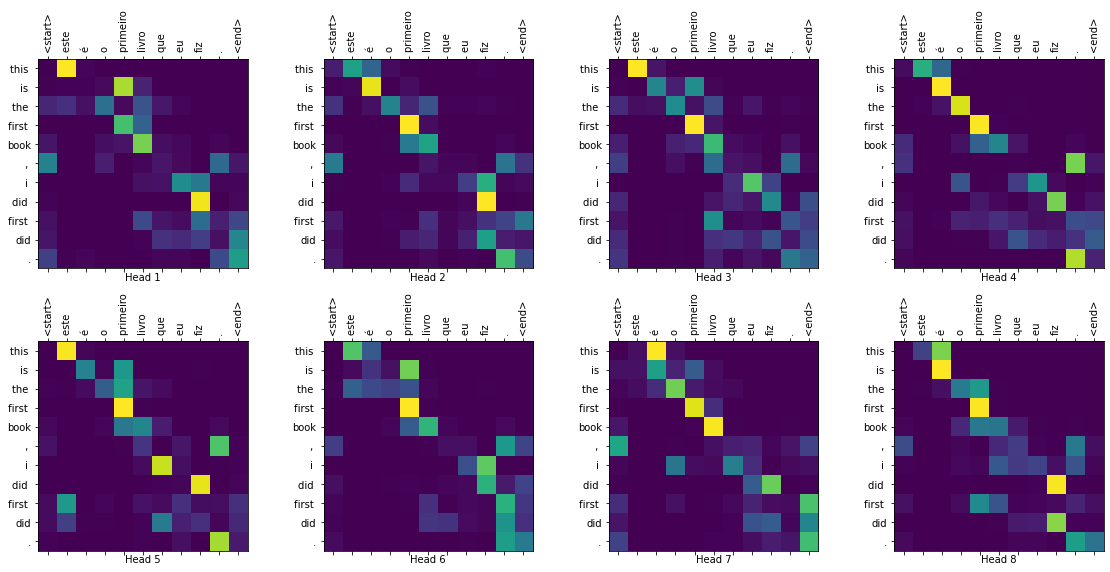

Real translation: this is the first book i've ever done.


In [50]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.

# The code below was just scrap for something

In [43]:
# Figuering out how the lookahead mask works
####################333
for inp, tar in train_dataset.take(1):
    targetInput = tar[:,:-1]
    
    inputPaddingMask, targetLookAheadAndPaddingMask = create_masks(inp, targetInput)
    
    embedding = tf.keras.layers.Embedding(input_dim=30000, output_dim=512)
    
    multiHeadAttentionLayer1Decoder = MultiHeadAttention(512, 8)
    
    targetInput = embedding(targetInput)
    
    scaled_dot_product_attention(v=targetInput, k=targetInput, q=targetInput, mask=targetLookAheadAndPaddingMask)
    
    

v=targetInput
k=targetInput
q=targetInput
mask=targetLookAheadAndPaddingMask
    
matmul_qk = tf.matmul(q, k, transpose_b=True)  

# It seems the variance of the matrix multiplication above is equal to,
# or close to, the last dimension of q and k (same number).
# To make this scaled you just have to divide by the std. The std is the square root of the
# variance. So, when you divide by the std you know have a scaled matrix that will
# have a mean=0 and std=1
var = tf.cast(tf.shape(k)[-1], tf.float32)
std = tf.math.sqrt(var)
scaled_attention_logits = matmul_qk / std

# # add the mask to the scaled tensor.
# if mask is not None:
#     scaled_attention_logits += (mask * -1e9)  

# softmax is normalized on the last axis (seq_len_k) so that the scores
# add up to 1. Output shape (..., seq_len_q, seq_len_k)
attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  

attention_head_output = tf.matmul(attention_weights, v)
# targetLookAheadAndPaddingMask

# targetInput

# attention_head_output


targetInput

# targetLookAheadAndPaddingMask

<tf.Tensor: shape=(64, 38, 512), dtype=float32, numpy=
array([[[ 0.03252348,  0.01319523,  0.01949105, ...,  0.03923911,
          0.02725606, -0.00803493],
        [ 0.03857246, -0.04247294, -0.03307481, ...,  0.04022462,
          0.02318059,  0.02808947],
        [-0.01548079,  0.00955024, -0.01028364, ...,  0.0248175 ,
         -0.00633867, -0.04727761],
        ...,
        [ 0.03370781, -0.04292583,  0.03091688, ..., -0.04553634,
         -0.00685772,  0.01057408],
        [ 0.03370781, -0.04292583,  0.03091688, ..., -0.04553634,
         -0.00685772,  0.01057408],
        [ 0.03370781, -0.04292583,  0.03091688, ..., -0.04553634,
         -0.00685772,  0.01057408]],

       [[ 0.03252348,  0.01319523,  0.01949105, ...,  0.03923911,
          0.02725606, -0.00803493],
        [-0.02459559, -0.03046988,  0.04175122, ..., -0.01286032,
          0.04897854,  0.02765397],
        [ 0.01303225, -0.02265395, -0.03249881, ...,  0.00316264,
          0.02638182,  0.00175154],
        ...,